# Topos Data Engineer Intern Assignment

In [11]:
# Import libraries
from bs4 import BeautifulSoup
import requests
import pandas as pd
import geopandas as gpd
import shapely
from shapely.geometry import Polygon
from fiona.crs import from_epsg
import matplotlib.pylab as plt
import matplotlib.patches as mpatches
import urllib.request

In [2]:
# Function for getting soup from Wikipedia on top US cities
def soup_data():
    # Get the soup from Wikipedia
    cities_soup = BeautifulSoup(requests.get("https://en.wikipedia.org/wiki/" + \
                                 "List_of_United_States_cities_by_population").content, "html.parser")
    # Get all the data for all cities
    cities_data = cities_soup.findAll('table', attrs={'class':'wikitable sortable'})[0].findAll('tr')[1:]
    return cities_data

In [3]:
# To get all the basic info on each city
def basic_info():
    # Create a dictionary to store everything
    cities_dict = {}
    
    # Get the soup data
    cities_data = soup_data()
    
    # Iterate through each city
    for city in cities_data:
        
        # Create a dictionary for each city's individual data
        city_dict = {'name':None,'state':None,'st_cap':0,'st_large':0,'st_cap_large':0}
        
        # Get all the data
        all_info = city.findAll('td')
        
        # Check for DC
        if all_info[1].text.split('[')[0].strip() == 'Washington, D.C.':
            city_dict['fed_cap'] = 1
        else:
            city_dict['fed_cap'] = 0
        
        # Rank, city name, and state
        rank = int(all_info[0].text.strip())
        city_dict.update({'name':all_info[1].text.split('[')[0].strip()})
        city_dict.update({'state':all_info[2].text.strip()})
        
        # To get capital/largest city data
        style = str(all_info[1])
        if 'ffff99' in style:
            city_dict.update({'st_cap':1})
        elif 'cfecec' in style: 
            city_dict.update({'st_large':1})
        elif 'ccff99' in style:
            city_dict.update({'st_cap_large':1})
        
        # Get the rest of the data
        city_dict['pop'] = all_info[3].text.replace(',','').strip()
        city_dict['cen'] = all_info[4].text.replace(',','').strip()
        city_dict['area_mi'] = all_info[6].text.split()[0].replace(',','').strip()
        city_dict['area_km'] = all_info[7].text.split()[0].replace(',','').strip()
        city_dict['pd_mi'] = all_info[8].text.split('/')[0].replace(',','').strip()
        city_dict['pd_km'] = all_info[9].text.split('/')[0].replace(',','').strip()
        
        # Get the location
        loc_data = all_info[10].text.split('/')[2].strip().split(';')
        city_dict['lon'] = loc_data[1].split("\ufeff")[0].strip()
        city_dict['lat'] = loc_data[0]

        # To handle population change data
        change = all_info[5].text.strip().split('%')[0]
        if '+' in change:
            city_dict['change'] = change.split('+')[1]
        elif '−' in change:
            city_dict['change'] = '-' + change.split('−')[1]
        else:
            city_dict['change'] = 0 # this is for only one outlier case from Jurupa Valley, CA
    
        # Create the dict of dicts
        cities_dict[rank] = city_dict
    
    # Return the data to be fed into a dataframe
    return cities_dict

In [4]:
# Get more data from each city
def more_data():
    # Create a dictionary to store everything
    cities_dict = {}
    
    # Get the soup
    cities_data = soup_data()
    
    # Iterate through each city
    for city in cities_data:
                
        # Create a dictionary for each city's individual data
        city_dict = {'mayor_party':None,'elevation':None,'tz':None,'demo':None,'city_site':None}
        
        # Get the info for each city in the master table
        all_info = city.findAll('td')
        
        # Get the rank for dataframe merging later on
        rank = int(all_info[0].text.strip())

        # Get that city's wikipedia page URL
        wiki_site = 'https://en.wikipedia.org' + all_info[1].find('a').get('href')
        city_dict['wiki_site'] = wiki_site
        
        # Make a new soup out of that URL
        city_soup = BeautifulSoup(requests.get(wiki_site).content, "html.parser")
        
        # Go through the info summary at the top right of each page
        info_sum = city_soup.find('table', attrs={'class':'infobox geography vcard'}).tbody
        
        # Iterate
        for section in info_sum:
            if section.th:
                # Get the governing party for each mayor
                if ('Mayor' in section.th.text) and (len(section.td.findAll('a'))>1):
                    if any(i.isdigit() for i in section.td.findAll('a')[1].text) == True:
                        continue
                    else:
                        city_dict.update({'mayor_party':section.td.findAll('a')[1].text\
                                          .replace("(","").replace(")","")})
                # Get the elevation, time zone, and website
                if 'Elevation' in section.th.text:
                    city_dict.update({'elevation':section.td.text.split()[0].replace(',','')})
                if 'Time zone' in section.th.text:
                    city_dict.update({'tz':section.td.text.split()[0]})
                if 'Website' in section.th.text:
                    city_dict.update({'city_site':section.td.find('a').get('href')})
                
                # For demonym section specifically
                section_str = str(section)
                # Take the first demonym for each city
                if 'Demonym' in section_str:
                    if '<br/>' in section_str:
                        split1 = section_str.split('<td>')[1].split('<br/>')[0]
                        if '<sup' in split1:
                            city_dict.update({'demo':split1.split('<sup')[0]})
                        else:
                            city_dict.update({'demo':section_str.split('<td>')[1].split('<br/>')[0]\
                                              .replace(',','').strip()})
                    else:
                        if '<li>' in section_str:
                            city_dict.update({'demo':section.td.find('li').text})
                        else:
                            city_dict.update({'demo':section.td.text.split(',')[0].split('[')[0]\
                                              .replace(',','').strip()})
                    
        # Create the dict of dicts
        cities_dict[rank] = city_dict
            
    return cities_dict

In [5]:
# test = more_data()

In [6]:
# test_df = pd.DataFrame.from_dict(test, orient='index').reset_index().rename(columns={'index':'rank'})
# test_df.head()

In [7]:
# Make a dataframe from all the data
def df_maker():
    # Get the basic city info
    basic_data = basic_info()
    
    # Get the extra info from each city's wikipedia page
    extra_city_data = more_data()
    
    # Make dataframes
    basic_df = pd.DataFrame.from_dict(basic_data, orient='index').reset_index().rename(columns={'index':'rank'})\
                .apply(pd.to_numeric, errors='ignore')
    
    extra_df = pd.DataFrame.from_dict(extra_city_data, orient='index').reset_index().rename(\
                columns={'index':'rank'})

    # Merge them
    merged_dfs = basic_df.merge(extra_df, how='left', left_on='rank', right_on='rank')
    
    # Create geometry column for geoplotting
    merged_dfs['lonlat'] = list(zip(merged_dfs.lon, merged_dfs.lat))
    merged_dfs['geometry'] = merged_dfs[['lonlat']].applymap(lambda x:shapely.geometry.Point(x))
    merged_dfs = gpd.GeoDataFrame(merged_dfs)
    merged_dfs.crs = from_epsg(4326)
    merged_dfs = merged_dfs.to_crs(epsg=4269)

    return merged_dfs

In [12]:
# Create the dataframe
df = df_maker()
df.head()

,rank,name,state,st_cap,st_large,st_cap_large,fed_cap,pop,cen,area_mi,...,lat,change,mayor_party,elevation,tz,demo,city_site,wiki_site,lonlat,geometry
0,1,New York City,New York,0,1,0,0,8398748,8175133,301.5,...,40.6635,2.74,D,33,UTC−05:00,New Yorker,https://www.nyc.gov/,https://en.wikipedia.org/wiki/New_York_City,"(-73.9387, 40.6635)",POINT (-73.9387 40.6635)
1,2,Los Angeles,California,0,1,0,0,3990456,3792621,468.7,...,34.0194,5.22,D,305,UTC−08:00,Angeleno,https://www.lacity.org/,https://en.wikipedia.org/wiki/Los_Angeles,"(-118.4108, 34.0194)",POINT (-118.4108 34.0194)
2,3,Chicago,Illinois,0,1,0,0,2705994,2695598,227.3,...,41.8376,0.39,D,594,UTC−06:00,Chicagoan,http://www.cityofchicago.org,https://en.wikipedia.org/wiki/Chicago,"(-87.6818, 41.8376)",POINT (-87.6818 41.8376)
3,4,Houston,Texas,0,1,0,0,2325502,2100263,637.5,...,29.7866,10.72,D,80,UTC−6,Houstonian,http://www.houstontx.gov/,https://en.wikipedia.org/wiki/Houston,"(-95.3909, 29.7866)",POINT (-95.3909 29.7866)
4,5,Phoenix,Arizona,0,0,1,0,1660272,1445632,517.6,...,33.5722,14.85,None,1086,UTC−7,Phoenician,http://www.phoenix.gov,"https://en.wikipedia.org/wiki/Phoenix,_Arizona","(-112.0901, 33.5722)",POINT (-112.0901 33.5722)


In [13]:
# Number of missing values after full data scrape in each column
print("Columns with any missing data:")
print("")
for col in df.columns:
    if df[col].isnull().sum()>0:
        print("Column name: {}".format(col))
        print("Number of missing values: {} out of {} rows".format(df[col].isnull().sum(), df.shape[0]))
        print("")

Columns with any missing data:

Column name: mayor_party
Number of missing values: 190 out of 314 rows

Column name: elevation
Number of missing values: 6 out of 314 rows

Column name: demo
Number of missing values: 172 out of 314 rows



In [14]:
"""
Export data (withough headers in order to mimic the steps provided by Google Cloud: 
https://cloud.google.com/bigquery/docs/quickstarts/quickstart-web-ui)
"""
df.to_csv('cities.txt', header=False, index=False)

## Prepping data for BigQuery

Use the following query to reorder the data:

SELECT * FROM `topos-242022.topos.topos` ORDER BY rank

In [15]:
# To make sure data loads properly from saved file
test_load = pd.read_csv('cities.txt', header=None)
test_load.head()

,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
0,1,New York City,New York,0,1,0,0,8398748,8175133,301.5,...,40.6635,2.74,D,33,UTC−05:00,New Yorker,https://www.nyc.gov/,https://en.wikipedia.org/wiki/New_York_City,"(-73.9387, 40.6635)",POINT (-73.9387 40.6635)
1,2,Los Angeles,California,0,1,0,0,3990456,3792621,468.7,...,34.0194,5.22,D,305,UTC−08:00,Angeleno,https://www.lacity.org/,https://en.wikipedia.org/wiki/Los_Angeles,"(-118.4108, 34.0194)",POINT (-118.4108 34.0194)
2,3,Chicago,Illinois,0,1,0,0,2705994,2695598,227.3,...,41.8376,0.39,D,594,UTC−06:00,Chicagoan,http://www.cityofchicago.org,https://en.wikipedia.org/wiki/Chicago,"(-87.6818, 41.8376)",POINT (-87.6818 41.8376)
3,4,Houston,Texas,0,1,0,0,2325502,2100263,637.5,...,29.7866,10.72,D,80,UTC−6,Houstonian,http://www.houstontx.gov/,https://en.wikipedia.org/wiki/Houston,"(-95.3909, 29.7866)",POINT (-95.3909 29.7866)
4,5,Phoenix,Arizona,0,0,1,0,1660272,1445632,517.6,...,33.5722,14.85,NaN,1086,UTC−7,Phoenician,http://www.phoenix.gov,"https://en.wikipedia.org/wiki/Phoenix,_Arizona","(-112.0901, 33.5722)",POINT (-112.0901 33.5722)


In [16]:
# Get column names and data types to enter into BigQuery during table creation
columns = df.dtypes.index.tolist()
dtypes = df.dtypes.values

In [17]:
# Rename the data types so they align with Google's data type names for manual entry
for i in range(len(columns)):
    if dtypes[i] == 'int64':
        dtypes[i] = 'integer'
    elif dtypes[i] == 'float64':
        dtypes[i] = 'float'
    elif dtypes[i] == 'object':
        dtypes[i] = 'string'
    print(str(columns[i]) + ":" + str(dtypes[i]) + ",", end="")

rank:integer,name:string,state:string,st_cap:integer,st_large:integer,st_cap_large:integer,fed_cap:integer,pop:integer,cen:integer,area_mi:float,area_km:float,pd_mi:integer,pd_km:integer,lon:float,lat:float,change:float,mayor_party:string,elevation:string,tz:string,demo:string,city_site:string,wiki_site:string,lonlat:string,geometry:string,

## Plotting the data

With state boundary data available via the US Census TIGER/Line shapefiles, we can plot the data.

In [18]:
# # Pulling in shapefile boundaries for the US (uncomment to rerun):
# url = 'https://www2.census.gov/geo/tiger/TIGER2017/STATE/tl_2017_us_state.zip'
# urllib.request.urlretrieve(url, 'tl_2017_us_state.zip')
# !mkdir us_bound
# !unzip tl_2017_us_state.zip -d us_bound
# !rm -r tl_2017_us_state.zip

In [19]:
# Read in the file
us_shp = gpd.read_file('us_bound/tl_2017_us_state.shp')
us_shp.head()

,REGION,DIVISION,STATEFP,STATENS,GEOID,STUSPS,NAME,LSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
0,3,5,54,01779805,54,WV,West Virginia,00,G4000,A,62265662566,489840834,+38.6472854,-080.6183274,"POLYGON ((-81.747254 39.095379, -81.746354 39...."
1,3,5,12,00294478,12,FL,Florida,00,G4000,A,138911437206,31398800291,+28.4574302,-082.4091478,"(POLYGON ((-82.987477 24.625379, -82.987477 24..."
2,2,3,17,01779784,17,IL,Illinois,00,G4000,A,143784114293,6211277447,+40.1028754,-089.1526108,"POLYGON ((-91.185295 40.637803, -91.1751 40.64..."
3,2,4,27,00662849,27,MN,Minnesota,00,G4000,A,206229176104,18944967530,+46.3158148,-094.1996628,"POLYGON ((-96.784381 46.63050399999999, -96.78..."
4,3,5,24,01714934,24,MD,Maryland,00,G4000,A,25150696145,6980371026,+38.9466584,-076.6744939,"POLYGON ((-77.45880799999999 39.22027, -77.458..."


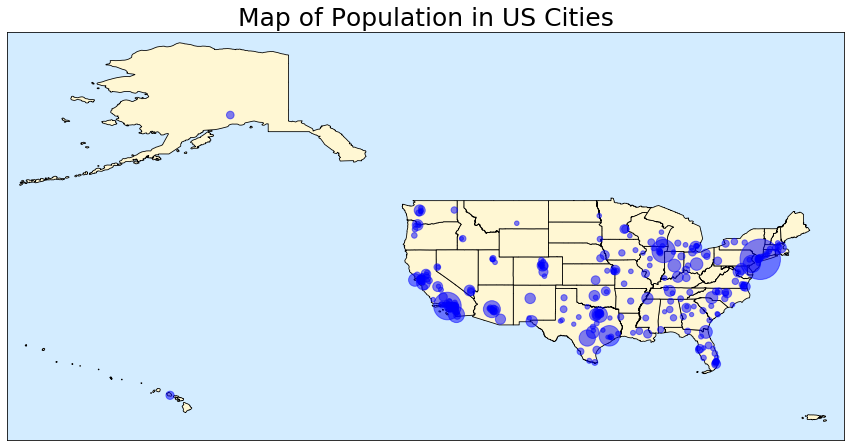

In [39]:
# Plotting total pop
f, ax = plt.subplots(figsize=(15, 15))
ax.set_facecolor('#d3ecff')
us_shp.plot(alpha=1,linewidth=0.8,ax=ax,color='#fff7d3',edgecolor='black')
ax.scatter(df.lon, df.lat, s=df.cen/5000, alpha=.5, color='b')
plt.title("Map of Population in US Cities", fontsize=25)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
# Manually setting x and y limits since US territories and parts of Alaska otherwise throw off the plot
ax.set_xlim(-181, -62)
ax.set_ylim(15, 73)
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
plt.show()

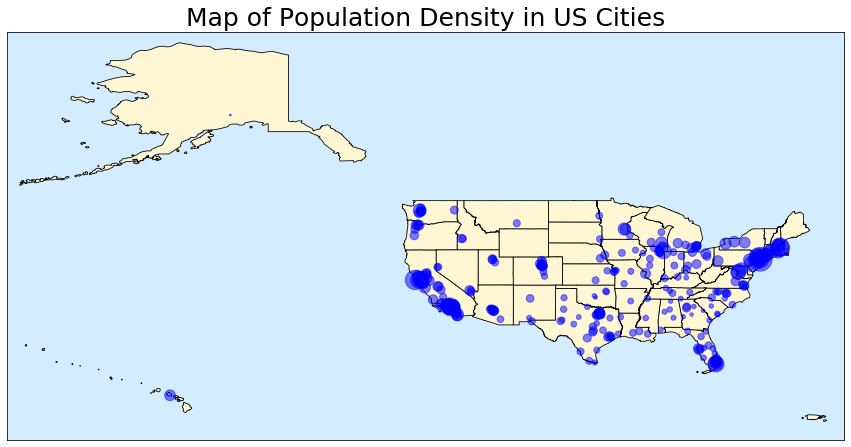

In [40]:
# Plotting pop density
f, ax = plt.subplots(figsize=(15, 15))
ax.set_facecolor('#d3ecff')
us_shp.plot(alpha=1,linewidth=0.8,ax=ax,color='#fff7d3',edgecolor='black')
ax.scatter(df.lon, df.lat, s=df.pd_mi/50, alpha=.5, color='b')
plt.title("Map of Population Density in US Cities", fontsize=25)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
ax.set_xlim(-181, -62)
ax.set_ylim(15, 73)
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
plt.show()

In [22]:
# Setting colors for the following two plots
colors = {'D':'blue',None:'green','I':'orange','R':'red','DFL':'pink','ID':'purple'}

# Create a patchlist for the legend
color_names = {'Democrat':'blue','Not listed on WP':'green','Independent':'orange','Republican':'red',\
               'Minnesota Democratic–Farmer–Labor Party':'pink','Independent Democrats':'purple'}
patchList = []
for key in color_names:
    data_key = mpatches.Patch(color=color_names[key], label=key)
    patchList.append(data_key)

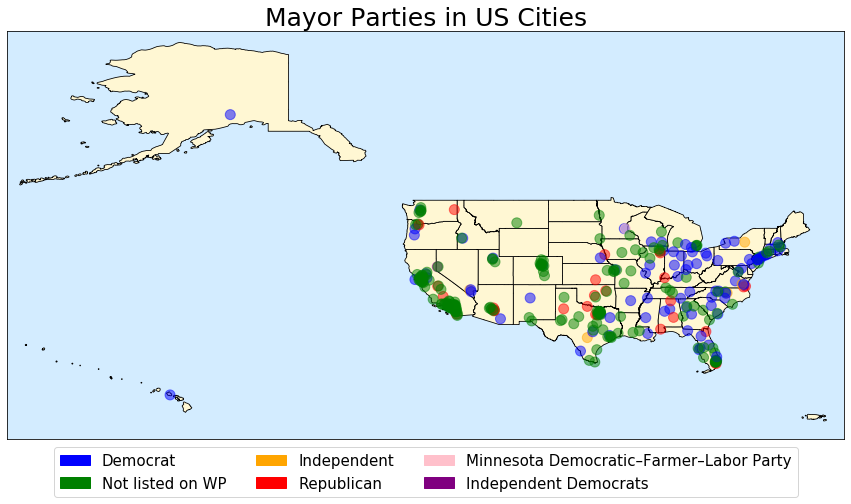

In [43]:
# Mayor parties (no size scaling)
f, ax = plt.subplots(figsize=(15, 15))
ax.set_facecolor('#d3ecff')
us_shp.plot(alpha=1,linewidth=0.8,ax=ax,color='#fff7d3',edgecolor='black')
ax.scatter(df.lon, df.lat, alpha=.5, s=100, c=df.mayor_party.apply(lambda x: colors[x]))
plt.title("Mayor Parties in US Cities", fontsize=25)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
ax.set_xlim(-181, -62)
ax.set_ylim(15, 73)
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
plt.legend(handles=patchList, loc='upper center', bbox_to_anchor=(0.5, -0.001),ncol=3,fontsize=15)
plt.show()

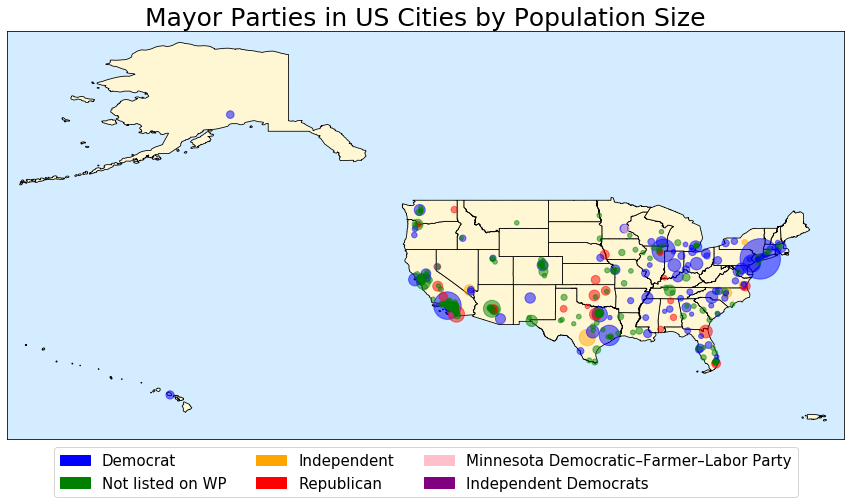

In [44]:
# Mayor parties (with size scaling)
f, ax = plt.subplots(figsize=(15, 15))
ax.set_facecolor('#d3ecff')
us_shp.plot(alpha=1,linewidth=0.8,ax=ax,color='#fff7d3',edgecolor='black')
ax.scatter(df.lon, df.lat, alpha=.5, s=df.cen/5000, c=df.mayor_party.apply(lambda x: colors[x]))
plt.title("Mayor Parties in US Cities by Population Size", fontsize=25)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
ax.set_xlim(-181, -62)
ax.set_ylim(15, 73)
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
plt.legend(handles=patchList, loc='upper center', bbox_to_anchor=(0.5, -0.001),ncol=3,fontsize=15)
plt.show()

### Note:

We can see that many of the larger US cities have Democratic mayors. Many cities, unfortunately, did not include an abbreviated party affiliation for the city's mayor in the summary tables of their respective Wikipedia pages and are shaded in green.